In [3]:


from sklearn.preprocessing import OneHotEncoder, LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


# 加载工作日数据
df_workday = pd.read_csv('rf_daily_workday.csv', parse_dates=['date'])

# 特征工程
def feature_engineering_classification(df):
    # 时间特征
    df['day_of_year'] = df['date'].dt.dayofyear
    df['is_month_start'] = df['date'].dt.is_month_start.astype(int)
    
    # 历史风险特征
    df = df.sort_values(['station_id', 'date'])
    df['prev_risk'] = df.groupby('station_id')['shortage_risk'].shift(1)
    
    # 站点容量特征
    df['capacity_util'] = df['daily_trips'] / df['nbdocks']
    
    # 天气风险特征
    df['rain_risk'] = df['is_rain'] * df['temperature']
    
    return df.dropna(subset=['prev_risk'])

df_workday = feature_engineering_classification(df_workday)

# 特征选择
features = [
    'nbdocks', 'cluster', 'month', 'day_of_week', 'temperature', 
    'humidity', 'wind_speed', 'is_rain', 'day_of_year', 'is_month_start',
    'prev_risk', 'capacity_util', 'rain_risk'
]
RSEED = 42

# 1) 目标与特征
target = 'risk_level'
X = df_workday[features].copy()
y = df_workday[target].copy()

# 2) 标签编码
le = LabelEncoder()
y_encoded = le.fit_transform(y)

# 3) 先切分（分层，防止不平衡偏移）
X_train, X_test, y_train, y_test = train_test_split(
    X, y_encoded, test_size=0.2, random_state=RSEED, stratify=y_encoded
)

# 4) 预处理（在训练集上 fit，只在训练/测试上 transform）
cat_features = ['cluster', 'month', 'day_of_week']
num_features = [c for c in X.columns if c not in cat_features]

preprocessor = ColumnTransformer(
    transformers=[
        # OneHot 输出用致密矩阵，方便与数值列拼接并给 SMOTE 使用
        ('cat', OneHotEncoder(handle_unknown='ignore', sparse_output=False), cat_features),
        ('num', SimpleImputer(strategy='median'), num_features),
    ],
    remainder='drop',
    sparse_threshold=0.0
)

Xtr = preprocessor.fit_transform(X_train)   # 仅在训练集 fit
Xte = preprocessor.transform(X_test)

# 5) 仅在训练集上做 SMOTE（无泄漏）
smote = SMOTE(random_state=RSEED)
Xtr_res, ytr_res = smote.fit_resample(Xtr, y_train)

# 6) 训练模型
model_clf = RandomForestClassifier(
    n_estimators=150,
    class_weight='balanced',
    random_state=RSEED,
    n_jobs=-1
)
model_clf.fit(Xtr_res, ytr_res)

# 7) 评估
y_pred = model_clf.predict(Xte)
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print(f"Weighted F1: {f1_score(y_test, y_pred, average='weighted'):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, target_names=le.classes_))


Accuracy: 0.7204
Weighted F1: 0.7238

Classification Report:
              precision    recall  f1-score   support

   high_risk       0.43      0.50      0.46      4986
    low_risk       0.86      0.83      0.84     16482
 medium_risk       0.67      0.66      0.67     13560
serious_risk       0.73      0.76      0.74      4740

    accuracy                           0.72     39768
   macro avg       0.67      0.69      0.68     39768
weighted avg       0.73      0.72      0.72     39768



In [20]:
from sklearn.metrics import classification_report
import pandas as pd

# 生成分类报告字典
report_dict = classification_report(y_test, y_pred, target_names=le.classes_, output_dict=True)

# 转为 DataFrame
report_df = pd.DataFrame(report_dict).transpose()

# 保存为 CSV
report_df.to_csv("classification_report.csv", index=True)

print("已保存为 classification_report.csv")


已保存为 classification_report.csv


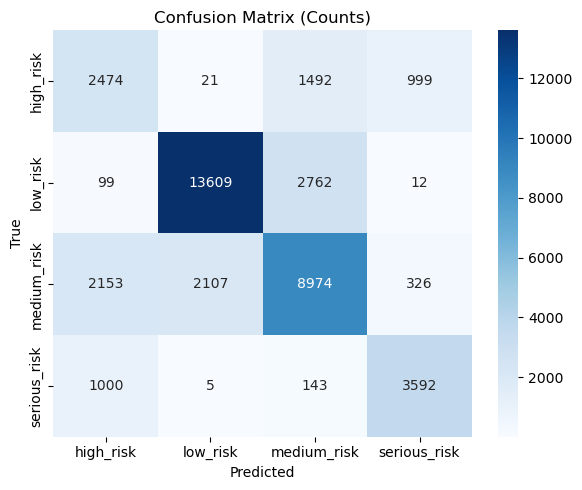

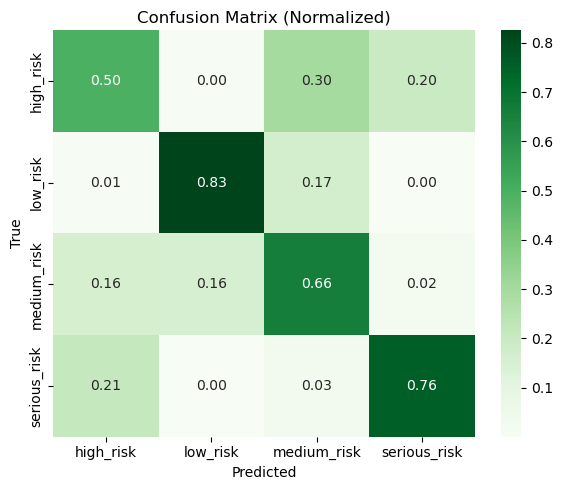

In [13]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

# 计数版
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (Counts)")
plt.tight_layout(); plt.show()

# 归一化（每一行=1）
cm_norm = confusion_matrix(y_test, y_pred, normalize='true')
plt.figure(figsize=(6,5))
sns.heatmap(cm_norm, annot=True, fmt='.2f', cmap='Greens',
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted"); plt.ylabel("True"); plt.title("Confusion Matrix (Normalized)")
plt.tight_layout(); plt.show()


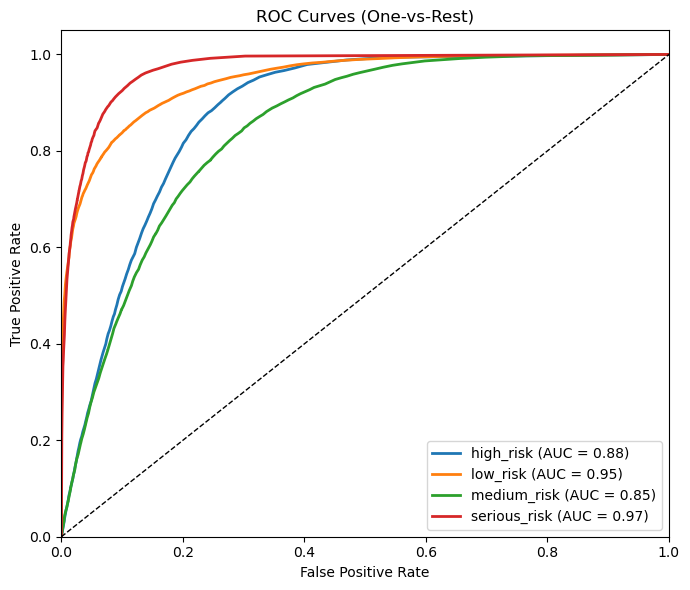

In [12]:
from sklearn.preprocessing import label_binarize
from sklearn.metrics import roc_curve, auc

# 概率输出：一定要用 Xte（预处理后的测试集）
y_score = model_clf.predict_proba(Xte)

# 将 y_test 二值化（one-vs-rest）
n_classes = len(le.classes_)
y_test_bin = label_binarize(y_test, classes=np.arange(n_classes))

# 逐类计算 ROC
fpr, tpr, roc_auc = {}, {}, {}
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test_bin[:, i], y_score[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# 画图
plt.figure(figsize=(7,6))
colors = ["C0","C1","C2","C3","C4","C5"]
for i, name in enumerate(le.classes_):
    plt.plot(fpr[i], tpr[i], lw=2, color=colors[i % len(colors)],
             label=f"{name} (AUC = {roc_auc[i]:.2f})")
plt.plot([0,1],[0,1],'k--',lw=1)
plt.xlim([0,1]); plt.ylim([0,1.05])
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curves (One-vs-Rest)")
plt.legend()
plt.tight_layout(); plt.show()


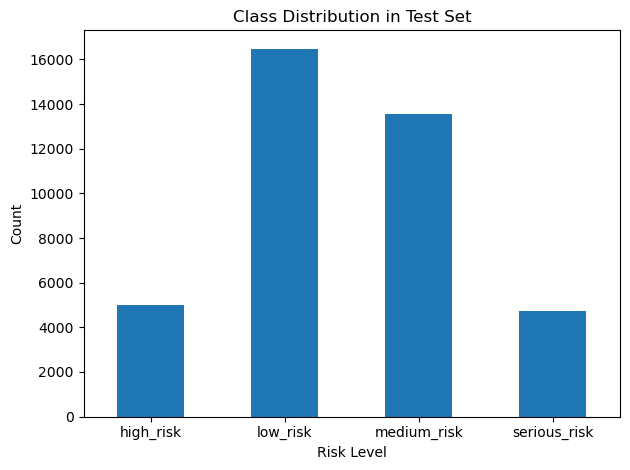

In [4]:
# 显示测试集各类别数量（反编码回原始标签名）
test_counts = pd.Series(y_test).value_counts().sort_index()
test_counts.index = le.inverse_transform(test_counts.index)

ax = test_counts.plot(kind='bar', rot=0, title='Class Distribution in Test Set')
ax.set_xlabel('Risk Level'); ax.set_ylabel('Count')
plt.tight_layout(); plt.show()


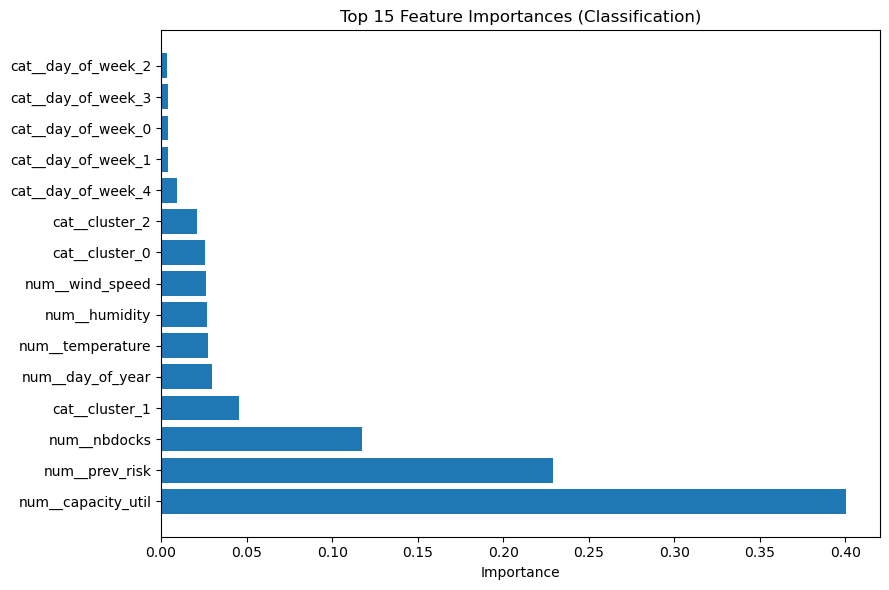

,Feature,Importance
0,num__capacity_util,0.400277
1,num__prev_risk,0.228872
2,num__nbdocks,0.117722
3,cat__cluster_1,0.045284
4,num__day_of_year,0.029591
5,num__temperature,0.027293
6,num__humidity,0.027111
7,num__wind_speed,0.026188
8,cat__cluster_0,0.025596
9,cat__cluster_2,0.021102


In [5]:
# 取编码后的特征名（与模型输入列顺序严格一致）
feat_names = preprocessor.get_feature_names_out()
importances = model_clf.feature_importances_

fi_df = pd.DataFrame({
    "Feature": feat_names,
    "Importance": importances
}).sort_values("Importance", ascending=False)

# 只画 Top 15
topk = 15
plt.figure(figsize=(9,6))
plt.barh(fi_df["Feature"].head(topk)[::-1], fi_df["Importance"].head(topk)[::-1])
plt.gca().invert_yaxis()
plt.title("Top 15 Feature Importances (Classification)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

# 如需表格查看
display(fi_df.reset_index(drop=True).head(30))


In [15]:
# 1) 取出与 X_test 对齐的原始记录
test_df = df_workday.loc[X_test.index].copy()

# 2) 贴上预测标签（英文标签名）
test_df['pred_code'] = y_pred
test_df['predicted_risk'] = le.inverse_transform(y_pred)

# 3)（可选）也保留真实标签做对比
test_df['true_code'] = y_test
test_df['true_risk'] = le.inverse_transform(y_test)


In [16]:
# 只保留严重缺车的记录；如需同时限定 cluster 在 [0,2]，把下一行的注释去掉
serious_df = test_df.query("predicted_risk == 'serious_risk'")
# serious_df = test_df.query("predicted_risk == 'serious_risk' and cluster in [0,2]")

# 各站点发生“严重缺车”的天数（或次数）
serious_by_station = (
    serious_df
    .groupby(['station_id','station_name'], as_index=False)
    .size()
    .rename(columns={'size':'serious_counts'})
    .sort_values('serious_counts', ascending=False)
)

# Top 20 热点站点
serious_top20 = serious_by_station.head(20)
serious_top20


,station_id,station_name,serious_counts
45,BikePoints_167,"Eccleston Place, Victoria",55
185,BikePoints_428,"Exhibition Road, Knightsbridge",54
69,BikePoints_203,"West Smithfield Rotunda, Farringdon",52
279,BikePoints_752,"London Street, Paddington",52
321,BikePoints_95,"Aldersgate Street, Barbican",52
139,BikePoints_340,"Bank of England Museum, Bank",51
283,BikePoints_762,"Storey's Gate, Westminster",51
166,BikePoints_386,"Moor Street, Soho",50
194,BikePoints_46,"Nesham Street, Wapping",50
149,BikePoints_356,"South Kensington Station, South Kensington",49


In [17]:
# day_of_week: 0=Mon ... 6=Sun（你的表只有工作日，所以一般 0~4）
by_dow = (
    (test_df['predicted_risk'] == 'serious_risk')
    .groupby(test_df['date'].dt.dayofweek)
    .mean()
    .rename('serious_rate')
)

# 示例：周一相对周五的提升（+41% 这类数字）
monday_rate = by_dow.loc[0]
friday_rate = by_dow.loc[4]
dow_increase = (monday_rate / friday_rate - 1) * 100
print(f"周一相对周五的‘严重缺车率’提升约：{dow_increase:.1f}%")
by_dow


周一相对周五的‘严重缺车率’提升约：58.6%


date
0    0.109547
1    0.142857
2    0.155847
3    0.139821
4    0.069053
Name: serious_rate, dtype: float64

In [18]:
flag_high_or_serious = test_df['predicted_risk'].isin(['high_risk','serious_risk'])

rain_rate = flag_high_or_serious[test_df['is_rain'] == 1].mean()
dry_rate  = flag_high_or_serious[test_df['is_rain'] == 0].mean()

rain_ratio = rain_rate / dry_rate  # 倍数
print(f"降雨使‘高/严重缺车’风险提升约 {rain_ratio:.2f} 倍")
print(f"(雨天={rain_rate:.3f}，晴天={dry_rate:.3f})")


降雨使‘高/严重缺车’风险提升约 nan 倍
(雨天=nan，晴天=0.268)
